# Fire Department Incident Analysis

https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3

#### Import Packages

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import Window 

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('max_columns',100)

#### Load Data Into Spark

In [5]:
df = spark\
    .read\
    .option("header",True)\
    .option("inferSchema",True)\
    .csv('RAWDATA/Fire_Department_Calls_for_Service.csv')

#### Properly Format Columns

In [6]:
# Format Dates
for dt_col in ['Call Date','Watch Date']:
    df = df.withColumn(dt_col, F.to_date(F.col(dt_col),format='mm/dd/yyyy'))

In [7]:
# Format Timestamps
for ts_col in ['Received DtTm','Entry DtTm','Dispatch DtTm','Response DtTm','On Scene DtTm','Transport DtTm',
              'Hospital DtTm','Available DtTm']:
    df = df.withColumn(ts_col, F.to_timestamp(ts_col, format='mm/dd/yyyy hh:mm:ss a'))

#### Preview Data

In [8]:
df_preview = df.limit(100).toPandas()

In [9]:
df_preview.head()

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,shape,Supervisor Districts,Fire Prevention Districts,Current Police Districts,Neighborhoods - Analysis Boundaries,Zip Codes,Neighborhoods (old),Police Districts,Civic Center Harm Reduction Project Boundary,HSOC Zones,Central Market/Tenderloin Boundary Polygon - Updated,Neighborhoods,SF Find Neighborhoods,Current Police Districts 2,Current Supervisor Districts
0,60640268,E17,6018058,Alarms,2006-01-05,2006-01-05,2006-01-05 18:37:01,2006-01-05 18:45:24,2006-01-05 18:45:39,NaT,2006-01-05 18:50:08,NaT,NaT,Other,2006-01-05 19:07:05,1300 Block of OAKDALE AVE,SF,94124.0,B10,17,0653,3,3,3,True,None,1,ENGINE,1,10,10,Bayview Hunters Point,"(37.732342352455, -122.386280381355)",060640268-E17,POINT (-122.386280381355 37.732342352455),8.0,10.0,3.0,1.0,58,1.0,3.0,NaN,NaN,NaN,86.0,86.0,2.0,9.0
1,60560284,T15,6015653,Structure Fire,2006-01-25,2006-01-25,2006-01-25 18:17:35,2006-01-25 18:17:35,2006-01-25 18:17:49,2006-01-25 18:18:41,2006-01-25 18:20:05,NaT,NaT,Fire,2006-01-25 18:21:16,GENEVA AV/TARA ST,SF,94112.0,B09,15,8313,3,3,3,False,None,1,TRUCK,1,9,11,Oceanview/Merced/Ingleside,"(37.721396869221, -122.448410646975)",060560284-T15,POINT (-122.448410646975 37.721396869221),6.0,9.0,5.0,24.0,28861,24.0,8.0,NaN,NaN,NaN,81.0,81.0,10.0,1.0
2,61480176,T05,6041096,Alarms,2006-01-28,2006-01-28,2006-01-28 12:39:31,2006-01-28 12:41:04,2006-01-28 12:41:11,2006-01-28 12:42:01,2006-01-28 12:43:29,NaT,NaT,Other,NaT,1500 Block of EDDY ST,SF,94115.0,B05,05,3624,3,3,3,False,None,1,TRUCK,1,5,5,Western Addition,"(37.781269356473, -122.433140098256)",061480176-T05,POINT (-122.433140098256 37.781269356473),11.0,15.0,6.0,39.0,29490,41.0,9.0,NaN,NaN,NaN,97.0,97.0,4.0,11.0
3,61180215,M36,6032760,Medical Incident,2006-01-28,2006-01-28,2006-01-28 12:59:36,2006-01-28 13:02:52,2006-01-28 13:03:46,2006-01-28 13:05:24,2006-01-28 13:06:02,NaT,NaT,Patient Declined Transport,2006-01-28 13:10:33,600 Block of STEVENSON ST,SF,94103.0,B02,01,2316,3,3,3,True,None,1,MEDIC,1,2,6,South of Market,"(37.779523171162, -122.412639291793)",061180215-M36,POINT (-122.412639291793 37.779523171162),9.0,8.0,2.0,34.0,28853,34.0,2.0,1.0,1.0,1.0,32.0,32.0,5.0,10.0
4,61030317,RC2,6028690,Medical Incident,2006-01-13,2006-01-13,2006-01-13 16:24:38,2006-01-13 16:25:50,2006-01-13 16:27:01,2006-01-13 16:28:01,2006-01-13 16:32:03,NaT,NaT,Other,2006-01-13 16:47:15,700 Block of 35TH AVE,SF,94121.0,B07,34,7252,3,3,3,True,None,1,RESCUE CAPTAIN,2,7,1,Outer Richmond,"(37.774876893512, -122.495176037656)",061030317-RC2,POINT (-122.495176037656 37.774876893512),2.0,11.0,9.0,29.0,55,26.0,6.0,NaN,NaN,NaN,8.0,8.0,8.0,4.0


#### Quick EDA to Understand Data Characteristics

In [10]:
df_counts_call_date = df\
    .groupBy('Call Date')\
    .agg(F.countDistinct('Incident Number').alias('Unique Incidents'),
         F.count('Call Date').alias('Total Calls'))\
    .toPandas()

In [11]:
df_counts_call_date['Call Date'] = pd.to_datetime(df_counts_call_date['Call Date'])

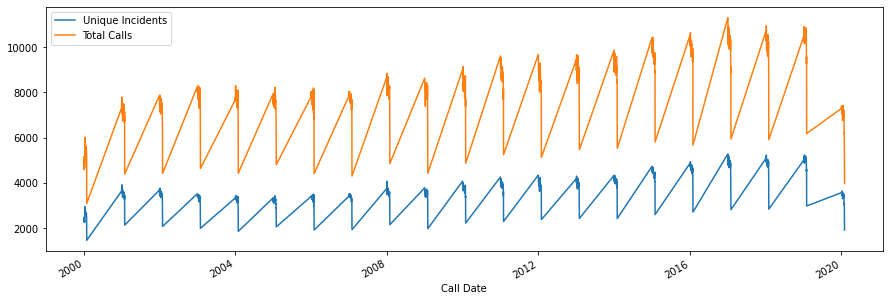

In [12]:
df_counts_call_date.set_index('Call Date').sort_index().plot(figsize=[15,5]);

In [13]:
df_counts_call_date['CallYear'] = df_counts_call_date['Call Date'].dt.year.astype(str)
df_counts_call_date['CallMonth'] = df_counts_call_date['Call Date'].dt.month

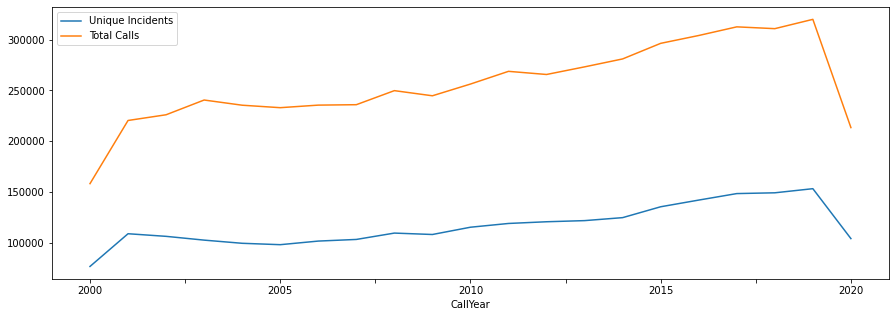

In [14]:
df_counts_call_date.groupby('CallYear')[['Unique Incidents','Total Calls']].sum().plot(figsize=[15,5])

In [15]:
df_counts_call_date.groupby(['CallYear','CallMonth'])[['Unique Incidents','Total Calls']].sum()

,,Unique Incidents,Total Calls
CallYear,CallMonth,,
2000,1,76660,158154
2001,1,108856,220328
2002,1,106285,225951
2003,1,102565,240457
2004,1,99447,235353
2005,1,98080,232919
2006,1,101630,235440
2007,1,103238,235856
2008,1,109491,249690


In [16]:
df_counts_call_type = df\
    .groupBy('Call Date','Call Type')\
    .agg(F.countDistinct('Incident Number').alias('Unique Incidents'),
         F.count('Call Date').alias('Total Calls'))\
    .toPandas()

In [17]:
df_counts_call_type['Call Date'] = pd.to_datetime(df_counts_call_type['Call Date'])

In [18]:
df_counts_call_type.groupby('Call Type').sum().sort_values('Unique Incidents', ascending=False).head(10)

,Unique Incidents,Total Calls
Call Type,,
Medical Incident,1772267,3515505
Alarms,196231,584187
Structure Fire,156893,672264
Traffic Collision,78585,220132
Citizen Assist / Service Call,64116,80370
Other,61605,85131
Outside Fire,44263,66021
Electrical Hazard,14138,16217
Elevator / Escalator Rescue,12873,14540


#### Define "turnout times"

In [19]:
df = df\
    .withColumn('TurnoutTime_sec', F.col('Response DtTm').cast('long') - F.col('Dispatch DtTm').cast('long'))\
    .withColumn('TurnoutTime_min', F.col('TurnoutTime_sec')/60)

#### Create Features to Identify "Evening incidents"

In [20]:
df = df\
    .withColumn('Evening Incident', F.when((F.hour('Dispatch DtTm')>= 18)&(F.hour('Dispatch DtTm')< 23),"YES").otherwise("NO"))

In [21]:
df_incident_types = df.groupby('Evening Incident')\
    .agg(F.countDistinct('Incident Number').alias('Unique Incidents'),
         F.mean('TurnoutTime_min').alias('Average Turnout Time (min)'))\
    .toPandas()

In [22]:
df_incident_types

,Evening Incident,Unique Incidents,Average Turnout Time (min)
0,YES,584652,2.027072
1,NO,1865403,3.029959


#### Create Features to Identify "back to back responses"
- Create a feature that increments by 1 for each call
- Join on that count - 1 to get the last incident time for each unit
- Flag units that have become available less than 10 minutes ago

In [23]:
# Create Column with Row Number by Call Date and Unit ID
w = Window.partitionBy(df['Call Date'],df['Unit ID']).orderBy(df['Available DtTm'])
df = df.withColumn('rnum',F.row_number().over(w))

# Create dataframe with prior call's available time
df_shift = df.select('Call Date','Unit ID','Available DtTm','rnum')
# Add 1 to row number to join to master dataframe
df_shift = df_shift.withColumn('rnum', F.col('rnum')+1)
# Rename Column
df_shift = df_shift.withColumnRenamed('Available DtTm','Prior Available DtTm')

# Join on Prior Call's Available Time
df = df.join(df_shift, on=['Call Date','Unit ID','rnum'], how='left')

# Calculate Time since Previous Incident
df = df.withColumn('TimeSinceLastAvailable_sec', F.col('Dispatch DtTm').cast('long') - F.col('Prior Available DtTm').cast('long'))\
    .withColumn('TimeSinceLastAvailable_min', F.col('TimeSinceLastAvailable_sec')/60)

In [24]:
df_pandas = df.filter(F.col('Call Date')=='2019-01-31').toPandas()

df_pandas.TimeSinceLastAvailable_min.describe()

count     5999.000000
mean       686.086962
std       5439.536201
min       -155.150000
25%        -25.758333
50%         -0.483333
75%         16.800000
max      44635.516667
Name: TimeSinceLastAvailable_min, dtype: float64

In [25]:
df_pandas[df_pandas['Unit ID']=='E06'].sort_values('Available DtTm').head(10)

,Call Date,Unit ID,rnum,Call Number,Incident Number,Call Type,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,shape,Supervisor Districts,Fire Prevention Districts,Current Police Districts,Neighborhoods - Analysis Boundaries,Zip Codes,Neighborhoods (old),Police Districts,Civic Center Harm Reduction Project Boundary,HSOC Zones,Central Market/Tenderloin Boundary Polygon - Updated,Neighborhoods,SF Find Neighborhoods,Current Police Districts 2,Current Supervisor Districts,TurnoutTime_sec,TurnoutTime_min,Evening Incident,Prior Available DtTm,TimeSinceLastAvailable_sec,TimeSinceLastAvailable_min
4217,2019-01-31,E06,1,192430047,19103367,Traffic Collision,2019-01-30,2019-01-31 00:18:59,2019-01-31 00:21:26,2019-01-31 00:23:17,2019-01-31 00:24:36,2019-01-31 00:27:56,NaT,NaT,Cancelled,2019-01-31 00:33:01,0 Block of 0SB OCTAVIA ON,San Francisco,94102.0,B02,36,3311,2,2,2,True,Non Life-threatening,1,ENGINE,1,2,5,Hayes Valley,"(37.77313041828892, -122.42402552084026)",192430047-E06,POINT (-122.42402552084026 37.77313041828892),11.0,7.0,6.0,9.0,28852.0,10.0,9.0,NaN,NaN,NaN,26.0,26.0,4.0,11.0,79.0,1.316667,NO,NaT,NaN,NaN
542,2019-01-31,E06,2,190900126,19038220,Medical Incident,2019-01-30,2019-01-31 00:42:33,2019-01-31 00:45:38,2019-01-31 00:46:53,2019-01-31 00:48:52,2019-01-31 00:58:02,NaT,NaT,Code 2 Transport,2019-01-31 01:07:06,0 Block of 12TH ST,San Francisco,94103.0,B02,36,5116,2,3,3,True,Potentially Life-Threatening,1,ENGINE,2,2,6,Mission,"(37.774094856688, -122.420001436964)",190900126-E06,POINT (-122.420001436964 37.774094856688),9.0,8.0,2.0,20.0,28853.0,19.0,2.0,1.0,1.0,1.0,32.0,32.0,1.0,10.0,119.0,1.983333,NO,2019-01-31 00:33:01,832.0,13.866667
4664,2019-01-31,E06,3,192120094,19089937,Medical Incident,2019-01-30,2019-01-31 00:51:44,2019-01-31 00:56:10,2019-01-31 00:56:52,2019-01-31 00:58:35,2019-01-31 01:01:26,NaT,NaT,Patient Declined Transport,2019-01-31 01:16:38,300 Block of VALENCIA ST,San Francisco,94103.0,B02,06,5226,3,2,2,True,Non Life-threatening,1,ENGINE,1,2,8,Mission,"(37.767002028647774, -122.42215811039273)",192120094-E06,POINT (-122.42215811039273 37.767002028647774),5.0,8.0,7.0,20.0,28853.0,19.0,4.0,NaN,3.0,NaN,37.0,37.0,3.0,5.0,103.0,1.716667,NO,2019-01-31 01:07:06,-614.0,-10.233333
6065,2019-01-31,E06,4,191510117,19063719,Medical Incident,2019-01-30,2019-01-31 01:20:55,2019-01-31 01:20:55,2019-01-31 01:21:27,2019-01-31 01:23:14,2019-01-31 01:24:49,NaT,NaT,Code 2 Transport,2019-01-31 01:29:10,0 Block of PROSPER ST,San Francisco,94114.0,B05,06,5252,A,3,3,True,Potentially Life-Threatening,1,ENGINE,1,5,8,Castro/Upper Market,"(37.763517764087354, -122.43155357565182)",191510117-E06,POINT (-122.43155357565182 37.763517764087354),5.0,15.0,7.0,5.0,28862.0,3.0,4.0,NaN,NaN,NaN,38.0,38.0,3.0,5.0,107.0,1.783333,NO,2019-01-31 01:16:38,289.0,4.816667
2257,2019-01-31,E06,5,190900172,19038227,Medical Incident,2019-01-30,2019-01-31 01:04:16,2019-01-31 01:08:10,2019-01-31 01:09:01,2019-01-31 01:09:13,2019-01-31 01:14:56,NaT,NaT,Patient Declined Transport,2019-01-31 01:40:00,3900 Block of 18TH ST,San Francisco,94114.0,B05,06,5417,2,2,2,True,Potentially Life-Threatening,1,ENGINE,1,5,8,Castro/Upper Market,"(37.761143168486, -122.431688789383)",190900172-E06,POINT (-122.431688789383 37.761143168486),5.0,15.0,7.0,5.0,28862.0,3.0,4.0,NaN,NaN,NaN,38.0,38.0,3.0,5.0,12.0,0.200000,NO,2019-01-31 01:29:10,-1209.0,-20.150000
4547,2019-01-31,E06,6,192120170,19089948,Medical Incident,2019-01-30,2019-01-31 02:00:11,2019-01-31 02:00:49,2019-01-31 02:02:08,2019-01-31 02:04:26,2019-01-31 02:05:23,NaT,NaT,Code 2 Transport,2019-01-31 02:14:22,2000 Block of MARKET ST,San Francisco,94114.0

# Task 1a: Evening incidents have slower turnout times
Evening incidents are incidents that are created between the hours of 10:00 PM and 6:00 AM.

#### Prepare Pandas Data Frame for Analysis

In [26]:
df_incident_time = df\
    .select('Call Date','Evening Incident','Call Type','Unit Type','TurnoutTime_min','TimeSinceLastAvailable_min')\
    .toPandas()

In [27]:
df_incident_time['Call Date'] = pd.to_datetime(df_incident_time['Call Date'])
df_incident_time['Call Year'] = df_incident_time['Call Date'].dt.year

In [28]:
df_incident_time['TurnoutTime_min'] = df_incident_time['TurnoutTime_min'].astype(float)

## Quick Visualizations (Identify if Data Quality Issues Exist)

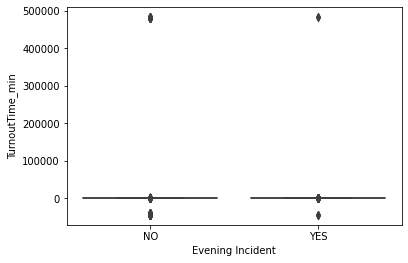

In [29]:
sns.boxplot(data=df_incident_time, x='Evening Incident', y='TurnoutTime_min');

In [30]:
# Remove Nulls
df_incident_time = df_incident_time[~df_incident_time.TurnoutTime_min.isnull()]

In [31]:
# Remove Turnout Times Greater than 1 day
df_incident_time = df_incident_time[df_incident_time.TurnoutTime_min<=(60*24)]

In [32]:
# Remove Turnout Times Less than 0
df_incident_time = df_incident_time[df_incident_time.TurnoutTime_min>0]

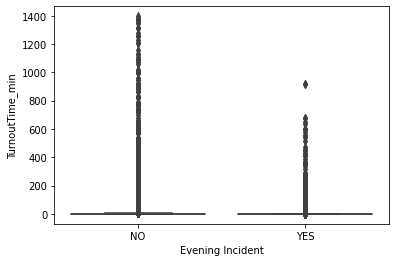

In [33]:
sns.boxplot(data=df_incident_time, x='Evening Incident', y='TurnoutTime_min');

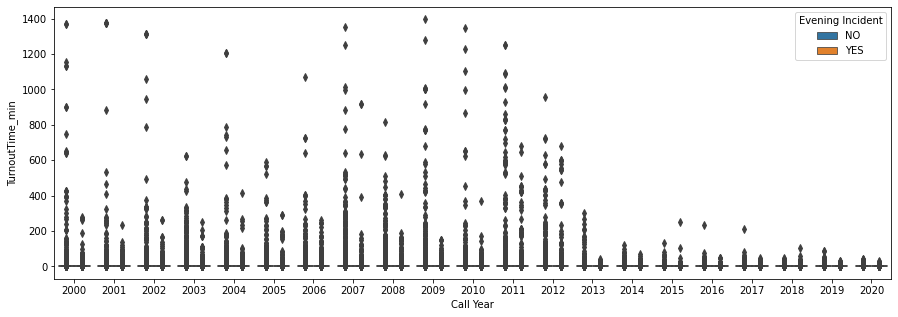

In [34]:
plt.figure(figsize=[15,5])
sns.boxplot(data=df_incident_time, x='Call Year', y='TurnoutTime_min', hue='Evening Incident');

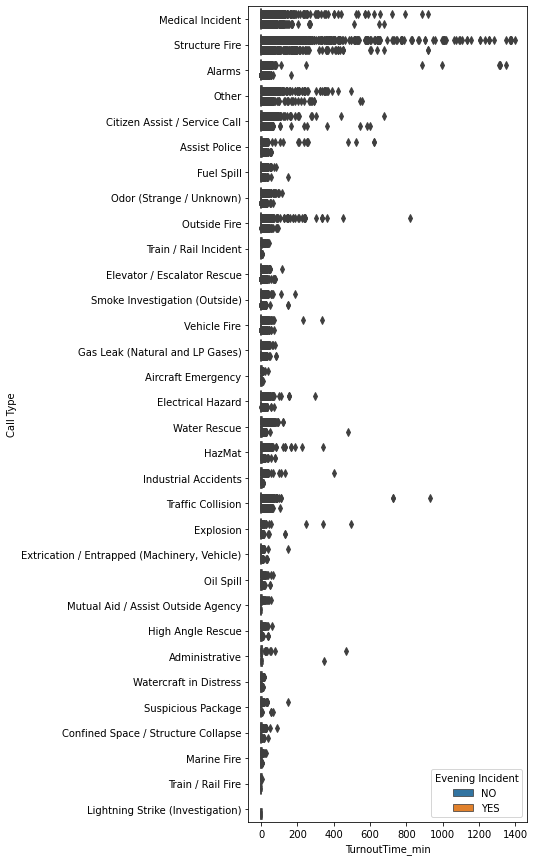

In [35]:
plt.figure(figsize=[5,15])
sns.boxplot(data=df_incident_time, y='Call Type', x='TurnoutTime_min', hue='Evening Incident');

#### Exclude Turnout Times > 5 minutes (Review Later)

In [36]:
time_filter_min = 5

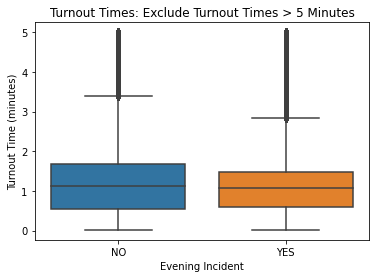

In [37]:
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], x='Evening Incident', y='TurnoutTime_min');
plt.title('Turnout Times: Exclude Turnout Times > 5 Minutes')
plt.ylabel('Turnout Time (minutes)')
plt.savefig('001_TurnoutTimes.png')

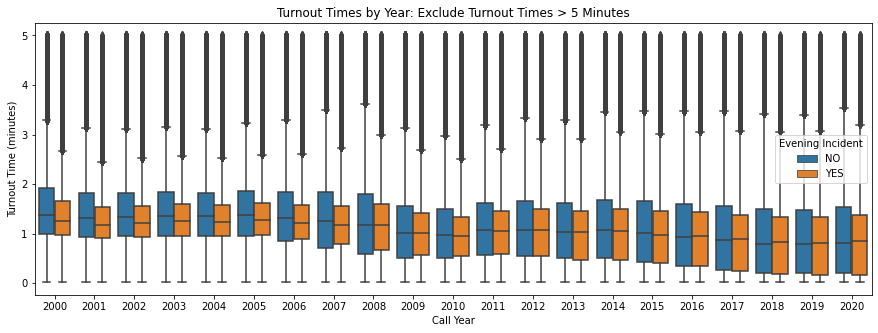

In [38]:
plt.figure(figsize=[15,5])
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], x='Call Year', y='TurnoutTime_min', hue='Evening Incident');
plt.title('Turnout Times by Year: Exclude Turnout Times > 5 Minutes')
plt.ylabel('Turnout Time (minutes)')
plt.savefig('002_TurnoutTimes_Year.png')

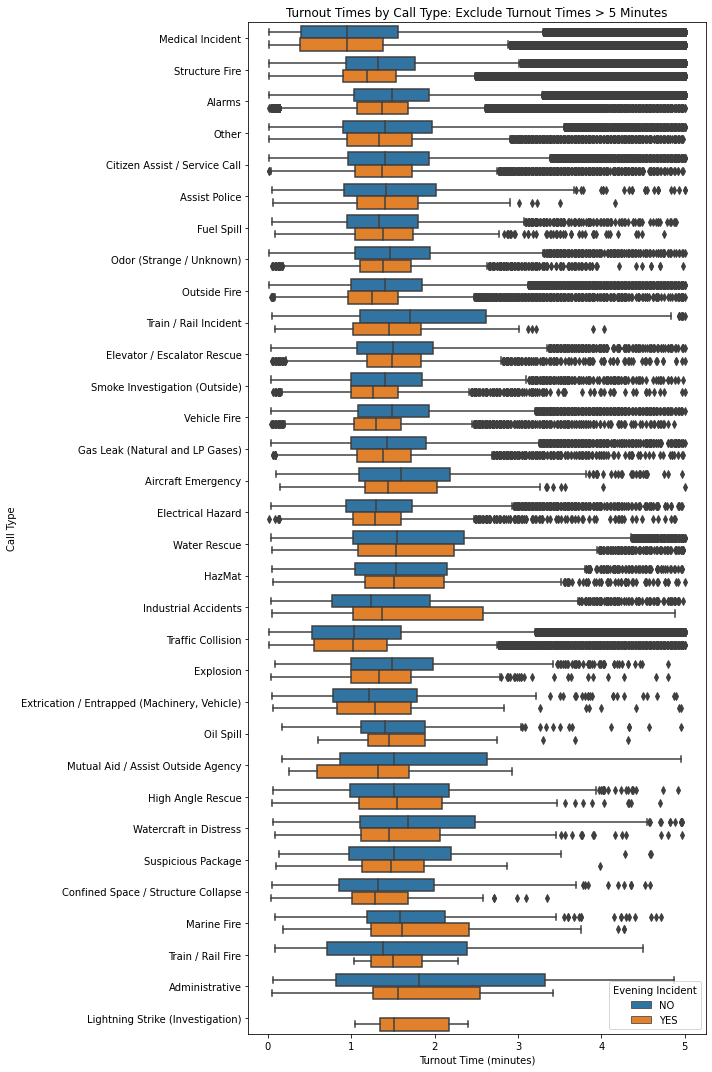

In [47]:
plt.figure(figsize=[10,15])
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], y='Call Type', x='TurnoutTime_min', hue='Evening Incident');
plt.title('Turnout Times by Call Type: Exclude Turnout Times > 5 Minutes')
plt.xlabel('Turnout Time (minutes)')
plt.tight_layout()
plt.savefig('003_TurnoutTimes_CallType.png')

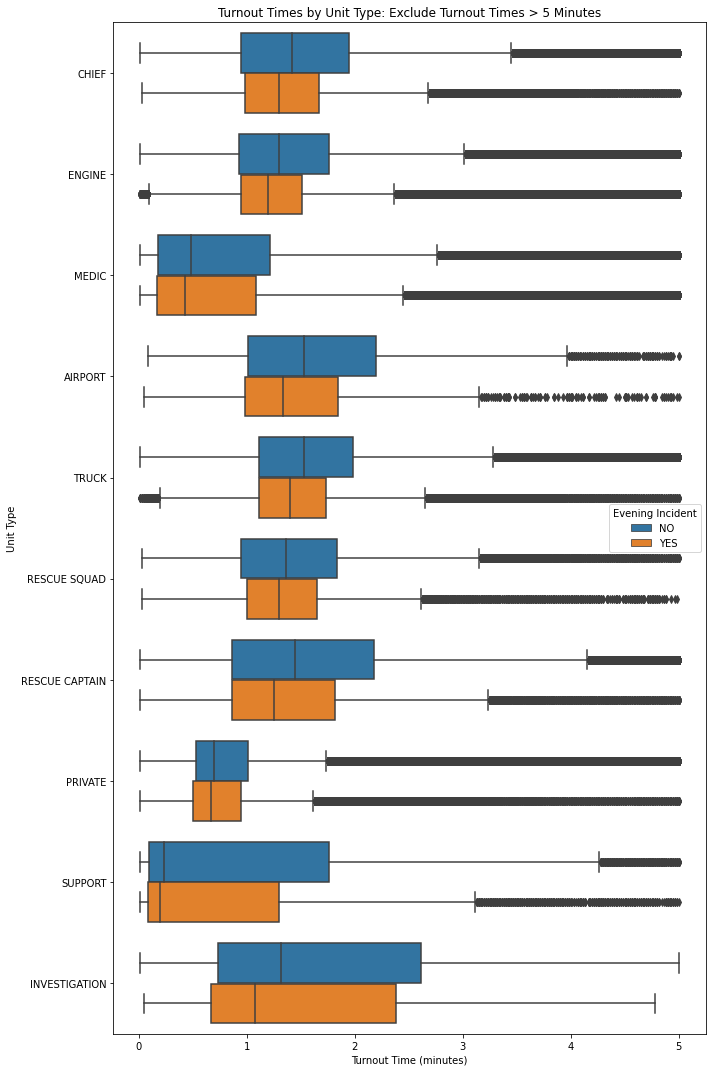

In [48]:
plt.figure(figsize=[10,15])
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], y='Unit Type', x='TurnoutTime_min', hue='Evening Incident');
plt.title('Turnout Times by Unit Type: Exclude Turnout Times > 5 Minutes')
plt.xlabel('Turnout Time (minutes)')
plt.tight_layout()
plt.savefig('004_TurnoutTimes_UnitType.png')

# Task 1b: Units with back to back responses have slower turnout times
A back to back response is defined by a unit being dispatched within 10 minutes of becoming available since the previous incident. 

## Quick Visualizations (Identify if Data Quality Issues Exist)

In [41]:
df_incident_time.TimeSinceLastAvailable_min.describe()

count    4.710150e+06
mean     1.750983e+01
std      1.522996e+03
min     -1.392733e+03
25%     -3.153333e+01
50%     -4.633333e+00
75%      7.900000e+00
max      4.824105e+05
Name: TimeSinceLastAvailable_min, dtype: float64

In [42]:
df_incident_time['BackToBack'] = np.where(df_incident_time.TimeSinceLastAvailable_min>10, "Outside 10 Minutes", "Within 10 Minutes")

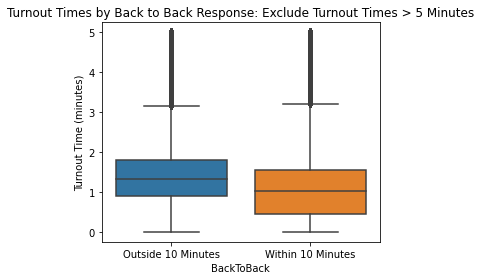

In [43]:
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], x='BackToBack', y='TurnoutTime_min');
plt.title('Turnout Times by Back to Back Response: Exclude Turnout Times > 5 Minutes')
plt.ylabel('Turnout Time (minutes)')
plt.tight_layout()
plt.savefig('005_TurnoutTimes_BackToBack.png')

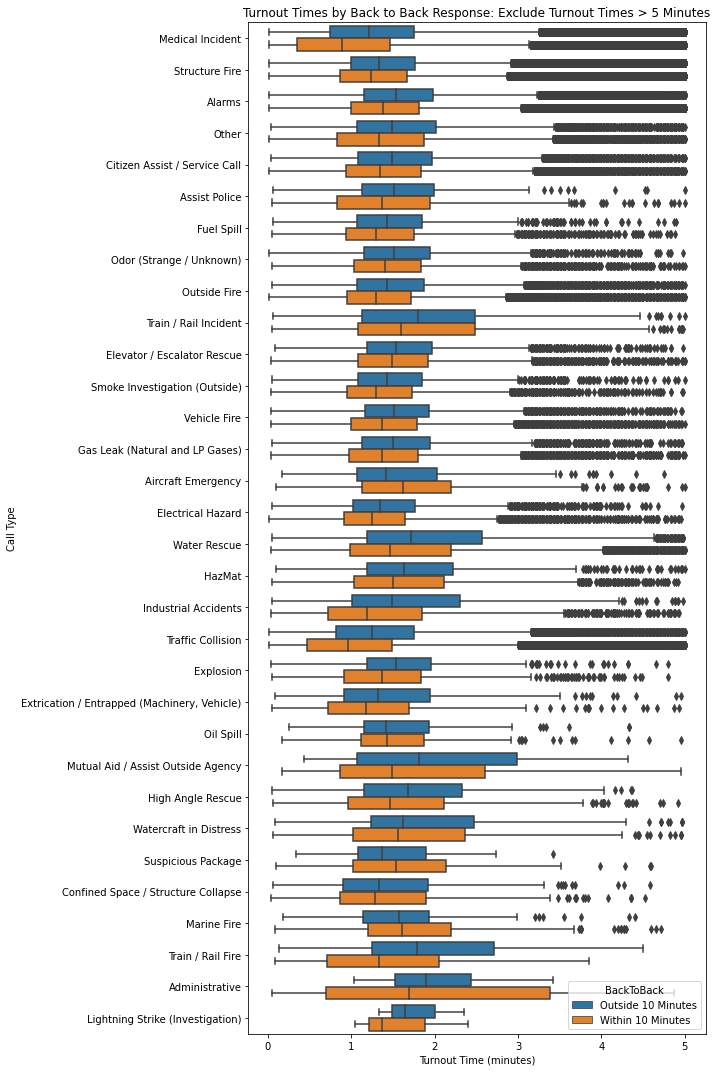

In [49]:
plt.figure(figsize=[10,15])
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], y='Call Type', x='TurnoutTime_min', hue='BackToBack');
plt.title('Turnout Times by Back to Back Response: Exclude Turnout Times > 5 Minutes')
plt.xlabel('Turnout Time (minutes)')
plt.tight_layout()
plt.savefig('006_TurnoutTimes_BackToBack_CallType.png')

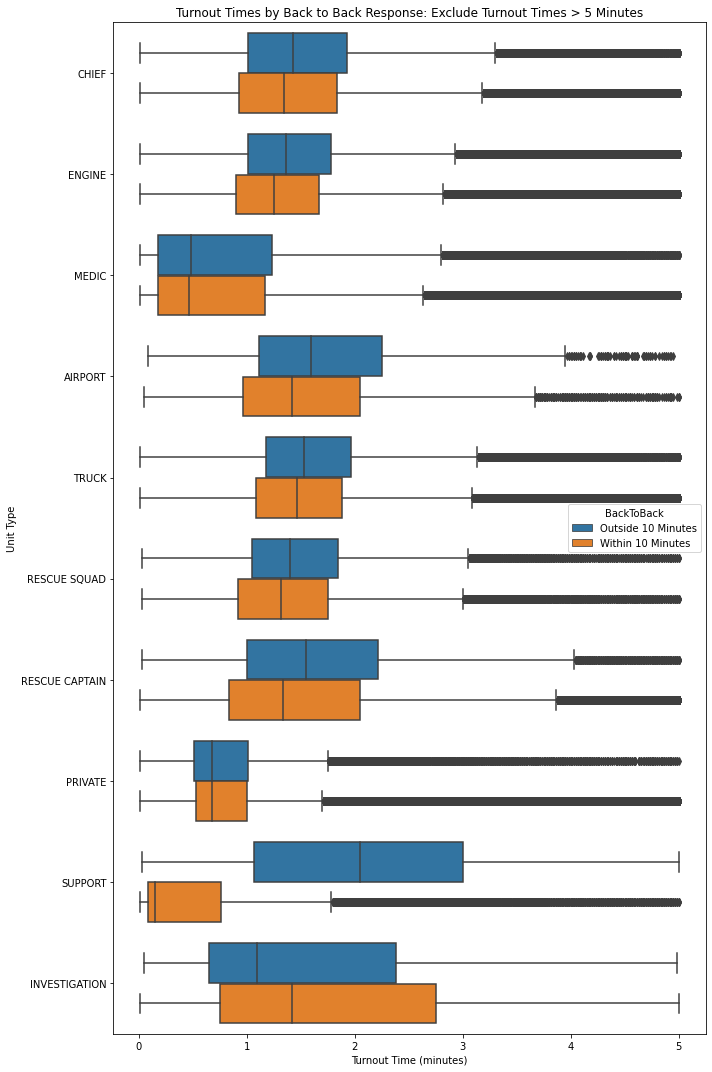

In [50]:
plt.figure(figsize=[10,15])
sns.boxplot(data=df_incident_time[df_incident_time.TurnoutTime_min<=time_filter_min], y='Unit Type', x='TurnoutTime_min', hue='BackToBack');
plt.title('Turnout Times by Back to Back Response: Exclude Turnout Times > 5 Minutes')
plt.xlabel('Turnout Time (minutes)')
plt.tight_layout()
plt.savefig('007_TurnoutTimes_BackToBack_UnitType.png')